In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import entropy




In [2]:

data = pd.read_csv('modified_data7.csv', encoding='cp1252')

# 필요없는 피처 날리기
data = data.drop("subbedOutTime", axis=1)
data = data.drop("position", axis=1)
data = data.drop("fantasyScore", axis=1)

# 포지션만 있고 세부 포지션 널값처리
# 'positionStringShort'의 널값이 있는 행 찾기
null_positions = data[data['positionStringShort'].isna()]

# 각 널값에 대해 처리
for index, row in null_positions.iterrows():
    # 현재 널값이 있는 행의 'name' 가져오기
    name = row['name']
    # 해당 'name'을 가진 모든 행에서 'positionStringShort'의 최빈값 찾기
    most_frequent_position = data[data['name'] == name]['positionStringShort'].mode()[0]
    # 널값 채우기
    data.at[index, 'positionStringShort'] = most_frequent_position

data = data.drop("name", axis=1)
# rating 널값 제거, 개수가 매우적어 없는거만 제거
data = data.dropna(subset=["rating"])

# x , y 나누기
data_x = data.drop("rating", axis=1)
data_y = data["rating"]

# 학습, 테스트 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)

# 'positionStringShort'와 'positionRow' 열 선택
x_train_cat = x_train[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder = OneHotEncoder()
# 원-핫 인코딩 적용
x_train_cat_1hot = cat_encoder.fit_transform(x_train_cat)
# positionStringShort, positionRow은 카테고리컬
x_train_num = x_train.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features = x_train_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled = scaler.fit_transform(numeric_features)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features.columns,
                                          index=x_train_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df = numeric_features_scaled_df.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled = x_train_num.copy()
data_num_scaled[numeric_features.columns] = numeric_features_scaled_df

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_train_cat_1hot_df = pd.DataFrame(x_train_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out(),
                                   index=x_train.index)

# 불리언 타입의 데이터만 선택
bool_features = x_train_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_train_prepared = pd.concat([data_num_scaled, bool_features, x_train_cat_1hot_df], axis=1)
x_train_prepared.columns

Index(['isCaptain', 'minutesPlayed', 'isGoalkeeper', 'goal', 'assist',
       'yellowCard', 'redCard', 'total_shots', 'accurate_passes_rate(%)',
       'chances_created', 'expected_goals(xG)',
       'expected_goals_on_target(xGOT)', 'expected_assists(xA)', 'xG+xA',
       'shot_accuracy(%)', 'blocked_shots', 'touches',
       'touches_in_opposition_box', 'passes_into_final_third',
       'long_balls_accuracy(%)', 'dispossessed', 'xG_Non_penalty',
       'tackles_won_rate(%)', 'clearances', 'headed_clearance',
       'defensive_actions', 'recoveries', 'dribbled_past', 'duels_won',
       'duels_lost', 'ground_duels_won_rate(%)', 'aerial_duels_won_rate(%)',
       'was_fouled', 'fouls_commited', 'dribble_success_rate(%)',
       'penalties_won', 'big_chances_missed', 'crosses_success_rate(%)',
       'isCaptain', 'isGoalkeeper', 'x0_AM', 'x0_CB', 'x0_CM', 'x0_DM',
       'x0_GK', 'x0_LB', 'x0_LM', 'x0_LW', 'x0_RB', 'x0_RM', 'x0_RW', 'x0_ST',
       'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x1_4'

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, x_train_prepared, y_train, scoring= "neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [4]:
print(rmse_scores)

[0.49878669 0.57314522 0.50444103 0.53483602 0.50997375 0.52826013
 0.52625845 0.58874402 0.49746706 0.51975552]


In [5]:
print(rmse_scores.mean())

0.5281667897504352


In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# cross_val_score가 완료된 후에는 학습된 모델이 저장되지 않습니다

lin_reg2 = LinearRegression()
lin_reg2.fit(x_train_prepared, y_train)

prediction = lin_reg2.predict(x_train_prepared)
lin_mse = mean_squared_error(y_train, prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse



0.5259331658044029

In [7]:
# MAE 계산
mae = mean_absolute_error(y_train, prediction)
mae

0.3687425096046599

In [8]:
x_test, y_test


# 'positionStringShort'와 'positionRow' 열 선택
x_test_cat = x_test[['positionStringShort', 'positionRow']].values
# OneHotEncoder 객체 생성
cat_encoder2 = OneHotEncoder()
# 원-핫 인코딩 적용
x_test_cat_1hot = cat_encoder2.fit_transform(x_test_cat)

# positionStringShort, positionRow은 카테고리컬
x_test_num = x_test.drop(["positionStringShort", "positionRow"], axis=1)

# 불리언 타입이 아닌 수치형 데이터만 선택
numeric_features2 = x_test_num.select_dtypes(include=['int64', 'float64'])
# StandardScaler 객체 생성
scaler2 = StandardScaler()
# 수치형 데이터에 표준화 적용
numeric_features_scaled2 = scaler.transform(numeric_features2)
# 스케일링된 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
numeric_features_scaled_df2 = pd.DataFrame(numeric_features_scaled2, columns=numeric_features2.columns,
                                          index=x_test_num.index)
# 데이터를 소수점 셋째 자리에서 반올림
numeric_features_scaled_df2 = numeric_features_scaled_df2.round(3)
# 스케일링된 수치형 데이터프레임을 원본 데이터프레임과 병합
data_num_scaled2 = x_test_num.copy()
data_num_scaled2[numeric_features2.columns] = numeric_features_scaled_df2

# 원-핫 인코딩된 데이터를 데이터프레임으로 변환
x_test_cat_1hot_df = pd.DataFrame(x_test_cat_1hot.toarray(), columns=cat_encoder2.get_feature_names_out(),
                                   index=x_test.index)

# 불리언 타입의 데이터만 선택
bool_features2 = x_test_num.select_dtypes(include=['bool'])


# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared = pd.concat([data_num_scaled2, bool_features2, x_test_cat_1hot_df], axis=1)

In [9]:
prediction2 = lin_reg2.predict(x_test_prepared)
lin_mse = mean_squared_error(y_test, prediction2)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
#아니 이렇게 다 작아버리면 어떡하지? 다른 모델도 해보자

0.498482523229098

In [45]:
# 테스트 데이터에 대한 예측을 생성합니다
y_pred = lin_reg2.predict(x_test_prepared)

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.35797835939914247


7.0236649082981035
7.013271320685217


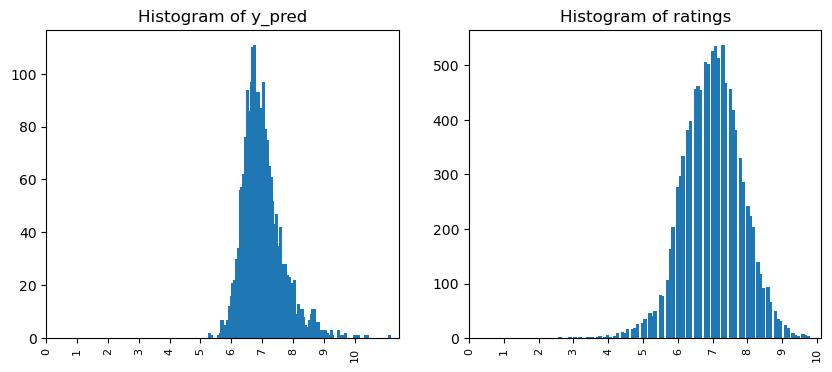

In [46]:
# y_pred에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of y_pred')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(y_pred.mean())
print(data['rating'].mean())

In [49]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(y_pred, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence


3.1558992487549484

In [11]:
print(x_train_prepared.columns)
print(x_train_prepared.shape)

Index(['isCaptain', 'minutesPlayed', 'isGoalkeeper', 'goal', 'assist',
       'yellowCard', 'redCard', 'total_shots', 'accurate_passes_rate(%)',
       'chances_created', 'expected_goals(xG)',
       'expected_goals_on_target(xGOT)', 'expected_assists(xA)', 'xG+xA',
       'shot_accuracy(%)', 'blocked_shots', 'touches',
       'touches_in_opposition_box', 'passes_into_final_third',
       'long_balls_accuracy(%)', 'dispossessed', 'xG_Non_penalty',
       'tackles_won_rate(%)', 'clearances', 'headed_clearance',
       'defensive_actions', 'recoveries', 'dribbled_past', 'duels_won',
       'duels_lost', 'ground_duels_won_rate(%)', 'aerial_duels_won_rate(%)',
       'was_fouled', 'fouls_commited', 'dribble_success_rate(%)',
       'penalties_won', 'big_chances_missed', 'crosses_success_rate(%)',
       'isCaptain', 'isGoalkeeper', 'x0_AM', 'x0_CB', 'x0_CM', 'x0_DM',
       'x0_GK', 'x0_LB', 'x0_LM', 'x0_LW', 'x0_RB', 'x0_RM', 'x0_RW', 'x0_ST',
       'x1_0', 'x1_1', 'x1_2', 'x1_3', 'x1_4'

In [12]:
eta = 0.1  # 학습률
n_iterations = 1000  # 반복 횟수
m = len(x_train_prepared)  # 샘플 개수

# x_train_prepared와 y_train을 NumPy 배열로 변환
X_b = np.c_[np.ones((m, 1)), x_train_prepared.values]  # x0 = 1 추가
y = y_train.values.reshape(-1, 1)

theta = np.random.randn(X_b.shape[1], 1)  # theta 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [50]:
# 테스트 데이터 준비 (1을 추가해야 합니다)
X_test_b = np.c_[np.ones((len(x_test_prepared), 1)), x_test_prepared.values]

# 테스트 데이터에 대한 예측 수행
y_pred = X_test_b.dot(theta)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)

Test MSE: 0.24839722482700727
Test RMSE: 0.49839464767090674


7.025546734212045
7.013271320685217


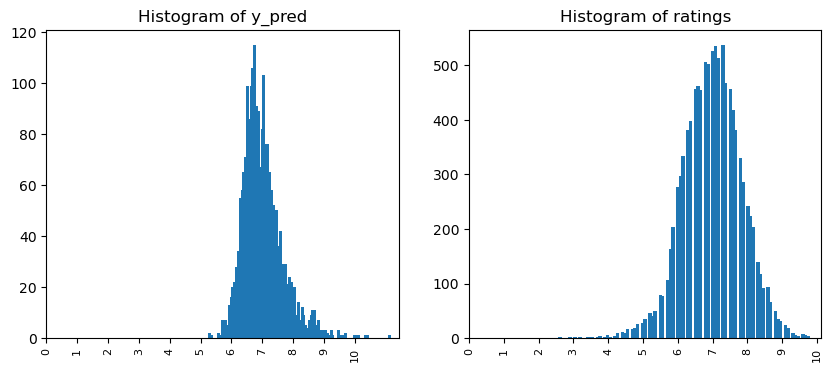

In [51]:
# y_pred에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of y_pred')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(y_pred.mean())
print(data['rating'].mean())

In [52]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(y_pred, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence

3.153032082294505

In [41]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=5000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(x_train_prepared, y_train)

# 테스트 데이터에 대한 예측을 생성합니다
prediction3 = sgd_reg.predict(x_test_prepared)

sgd_mse = mean_squared_error(y_test, prediction3)
sgd_rmse = np.sqrt(sgd_mse)
print("Root Mean Squared Error:", sgd_rmse)
# MAE 계산
sgd_mae = mean_absolute_error(y_test, prediction3)
print("Mean Absolute Error:", sgd_mae)


Root Mean Squared Error: 96763819300.21689
Mean Absolute Error: 6675011640.206768


-5455055087.759092
7.013271320685217


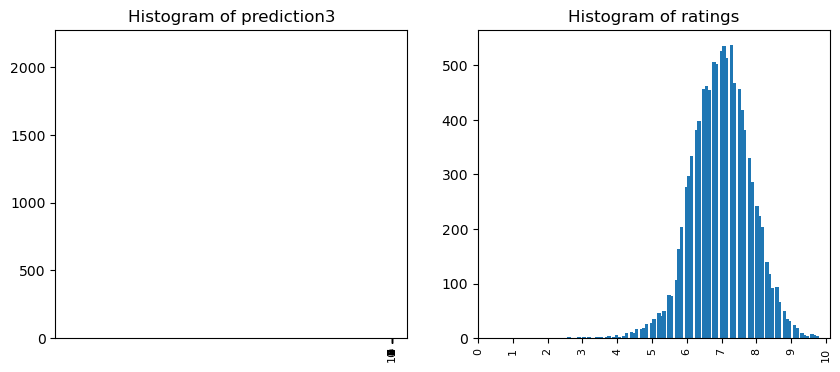

In [42]:
# prediction3에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction3, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of prediction3')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(prediction3.mean())
print(data['rating'].mean())

In [53]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(prediction3, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence

1.39146356477465

In [15]:
# L1 규제를 적용한 SGDRegressor 모델 생성
sgd_reg_l1 = SGDRegressor(max_iter=1000, tol=1e-3, penalty='l1', eta0=0.01)
sgd_reg_l1.fit(x_train_prepared, y_train)

# 테스트 데이터에 대한 예측 생성 및 성능 평가
prediction_l1 = sgd_reg_l1.predict(x_test_prepared)
mse_l1 = mean_squared_error(y_test, prediction_l1)
rmse_l1 = np.sqrt(mse_l1)
print("L1 규제 RMSE:", rmse_l1)
mae_l1 = mean_absolute_error(y_test, prediction_l1)
print("L1 규제 MAE:", mae_l1)
print(prediction_l1[0])
print(y_test.iloc[0])

L1 규제 RMSE: 0.5008315084192078
L1 규제 MAE: 0.3620803710881357
7.088743319979152
6.5


7.011903186801068
7.013271320685217


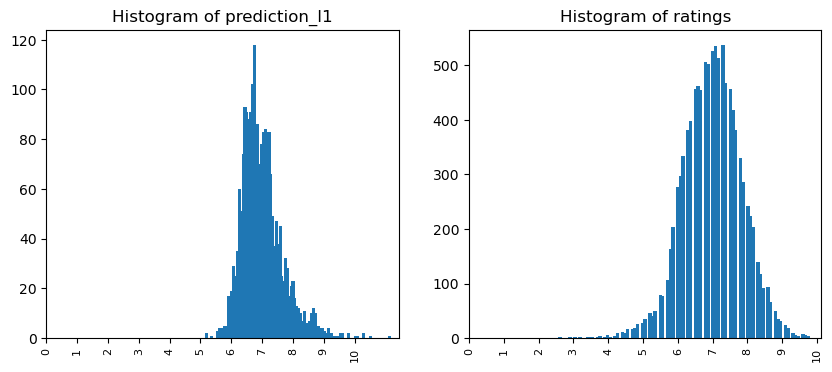

In [43]:
# prediction_l1에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction_l1, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of prediction_l1')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(prediction_l1.mean())
print(data['rating'].mean())

In [54]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(prediction_l1, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence

3.014316966321639

Text(0.5, 1.0, 'Histogram of ratings')

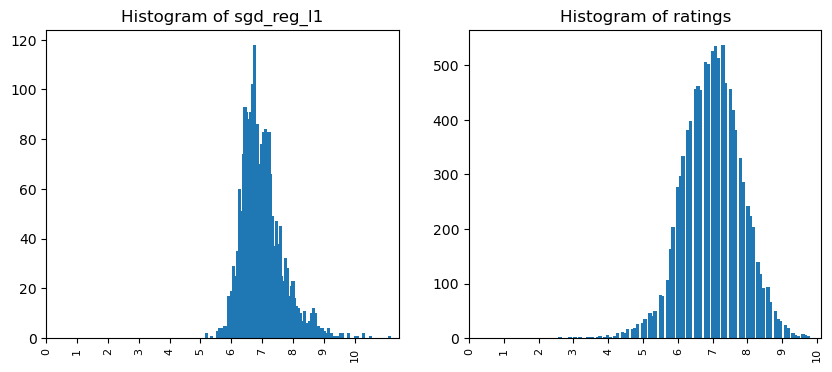

In [32]:
# sgd_reg_l1에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction_l1, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of sgd_reg_l1')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

In [16]:
# L2 규제를 적용한 SGDRegressor 모델 생성
sgd_reg_l2 = SGDRegressor(max_iter=1000, tol=1e-3, penalty='l2', eta0=0.01)
sgd_reg_l2.fit(x_train_prepared, y_train)

# 테스트 데이터에 대한 예측 생성 및 성능 평가
prediction_l2 = sgd_reg_l2.predict(x_test_prepared)
mse_l2 = mean_squared_error(y_test, prediction_l2)
rmse_l2 = np.sqrt(mse_l2)
print("L2 규제 RMSE:", rmse_l2)
mae_l2 = mean_absolute_error(y_test, prediction_l2)
print("L2 규제 MAE:", mae_l1)
print(prediction_l2[0])
print(y_test.iloc[0])

L2 규제 RMSE: 0.5011440045795805
L2 규제 MAE: 0.3620803710881357
7.108219434534199
6.5


7.039611645640569
7.013271320685217


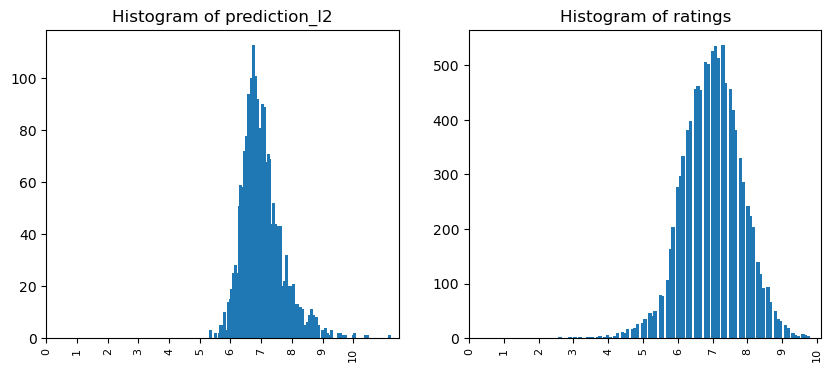

In [44]:
# prediction_l2에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction_l2, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of prediction_l2')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(prediction_l2.mean())
print(data['rating'].mean())

In [55]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(prediction_l2, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence

3.236126469120111

In [17]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x_train_prepared, y_train)

# 테스트 데이터에 대한 예측 생성 및 성능 평가
prediction_ela = sgd_reg_l2.predict(x_test_prepared)
mse_ela = mean_squared_error(y_test, prediction_ela)
rmse_ela = np.sqrt(mse_ela)
print("elastic 규제 RMSE:", rmse_ela)
mae_ela = mean_absolute_error(y_test, prediction_ela)
print("elastic 규제 MAE:", mae_l1)

elastic 규제 RMSE: 0.5011440045795805
elastic 규제 MAE: 0.3620803710881357


In [18]:
# SGDRegressor의 하이퍼파라미터 범위 설정
param_distribs = {
    'alpha': uniform(0.0001, 0.01),  # 규제 파라미터
    'penalty': ['l2', 'l1', 'elasticnet', 'None'],  # 규제 종류
    'eta0': uniform(0.01, 0.1)  # 학습률
}

# RandomizedSearchCV 설정
sgd_reg = SGDRegressor(max_iter=5000, tol=1e-3)
rnd_search = RandomizedSearchCV(sgd_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, return_train_score=True)

# 랜덤 탐색 실행
rnd_search.fit(x_train_prepared, y_train)

# 결과 평가
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# 최적의 파라미터
print("최적의 파라미터:", rnd_search.best_params_)

KeyboardInterrupt: 

In [ ]:
# 최적의 하이퍼파라미터로 SGDRegressor 모델 초기화
optimal_sgd_reg = SGDRegressor(alpha=0.001752669390630025, eta0=0.011563640674119394, penalty='l2', 
                               max_iter=1000, tol=1e-3)

# 모델 학습
optimal_sgd_reg.fit(x_train_prepared, y_train)

# 테스트 데이터에 대한 예측
y_pred_optimal = optimal_sgd_reg.predict(x_test_prepared)

# 성능 평가: MSE와 RMSE
optimal_mse = mean_squared_error(y_test, y_pred_optimal)
optimal_rmse = np.sqrt(optimal_mse)
print("Optimal RMSE:", optimal_rmse)

# 성능 평가: MAE
optimal_mae = mean_absolute_error(y_test, y_pred_optimal)
print("Optimal MAE:", optimal_mae)

In [56]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)

# 수치형 데이터에 대한 다항 특성 추가


x_train_num_poly = poly_features.fit_transform(data_num_scaled)
# 변환된 수치형 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
x_train_num_poly_df = pd.DataFrame(x_train_num_poly, index=x_train_num.index)
# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_train_prepared_poly = pd.concat([x_train_num_poly_df, bool_features, x_train_cat_1hot_df], axis=1)

print(x_train_prepared.shape)
print(x_train_prepared_poly.shape)



x_test_num_poly = poly_features.transform(data_num_scaled2)
# 변환된 수치형 데이터를 데이터프레임으로 변환 (원본 데이터프레임의 인덱스 사용)
x_test_num_poly_df = pd.DataFrame(x_test_num_poly, index=x_test_num.index)
# 스케일링된 수치형 데이터, 불리언 타입의 데이터, 원-핫 인코딩된 데이터 병합
x_test_prepared_poly = pd.concat([x_test_num_poly_df, bool_features2, x_test_cat_1hot_df], axis=1)




(8686, 58)
(8686, 799)


In [57]:
#  Polynomial Regression 모델 생성

sgd_reg_poly = SGDRegressor(max_iter=10000, tol=1e-3, penalty='l1', eta0=0.01)
sgd_reg_poly.fit(x_train_prepared_poly, y_train)

# 테스트 데이터에 대한 예측
prediction_sgd_reg_poly = sgd_reg_poly.predict(x_test_prepared_poly)

# 성능 평가: MSE와 RMSE
sgd_reg_poly_mse = mean_squared_error(y_test, prediction_sgd_reg_poly)
sgd_reg_poly_rmse = np.sqrt(sgd_reg_poly_mse)
print("Optimal RMSE:", sgd_reg_poly_rmse)

# 성능 평가: MAE
sgd_reg_poly_mae = mean_absolute_error(y_test, prediction_sgd_reg_poly)
print("Optimal MAE:", sgd_reg_poly_mae)

print(prediction_sgd_reg_poly[0])
print(y_test.iloc[0])

C:\Users\junhe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\junhe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Optimal RMSE: 3162221446739.2905
Optimal MAE: 463633801270.0816
232001141107.9271
6.5


In [58]:
#  Polynomial Regression 모델 생성
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(x_train_prepared_poly, y_train)

# 테스트 데이터에 대한 예측
prediction_lin_reg_poly = lin_reg_poly.predict(x_test_prepared_poly)

# 성능 평가: MSE와 RMSE
lin_reg_poly_mse = mean_squared_error(y_test, prediction_lin_reg_poly)
lin_reg_poly_rmse = np.sqrt(lin_reg_poly_mse)
print("RMSE:", lin_reg_poly_rmse)

# 성능 평가: MAE
lin_reg_poly_mae = mean_absolute_error(y_test, prediction_lin_reg_poly)
print("MAE:", lin_reg_poly_mae)

# 예측값과 실제값 출력
print("Predicted:", prediction_lin_reg_poly[15])
print("Actual:", y_test.iloc[15])


# 결과는 좋은데 -> 왜 rmse, mae가 이따위지?
# svm 커널 ->2차와 관련성??


C:\Users\junhe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RMSE: 16664727992.204895
MAE: 764270950.8544313
Predicted: 7.232023239135742
Actual: 7.3


C:\Users\junhe\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


7.039611645640569
7.013271320685217


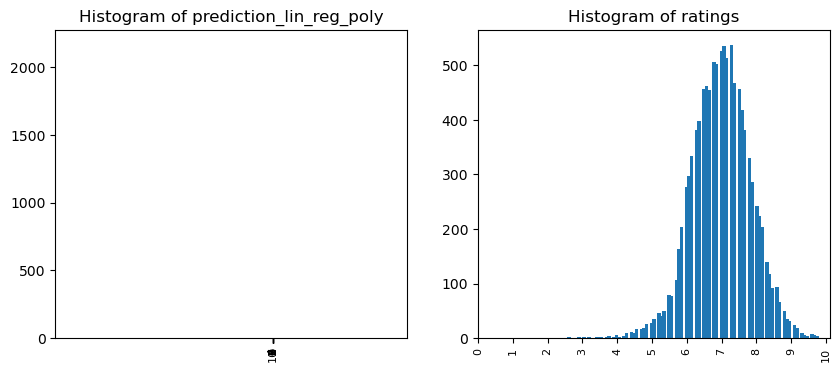

In [62]:
# prediction_lin_reg_poly에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction_lin_reg_poly, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of prediction_lin_reg_poly')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')

print(prediction_l2.mean())
print(data['rating'].mean())

In [61]:
# 히스토그램을 확률 분포로 변환
hist1, bin_edges1 = np.histogram(prediction_lin_reg_poly, bins=30, density=True)
hist2, bin_edges2 = np.histogram(data['rating'], bins=30, density=True)

# 0 값을 가진 히스토그램 bin을 처리 (KL Divergence는 0 로그 불가능)
hist1 = np.where(hist1 == 0, 1e-10, hist1)
hist2 = np.where(hist2 == 0, 1e-10, hist2)

# 쿨백-라이블러 발산 계산
kl_divergence = entropy(hist1, hist2)

kl_divergence

1.8854196119913882

7.013271320685217
7.0
0    7.3
Name: rating, dtype: float64


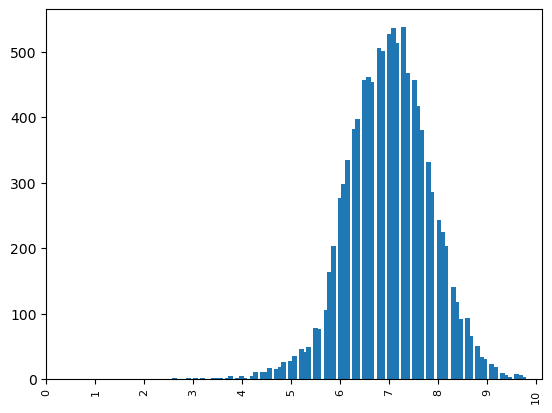

In [59]:
# target 'rating'에 대한 히스토그램
plt.hist(data['rating'], bins= 100, width = 0.1, align= 'left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation = 90 ,fontsize = 8)

# 평균, 중간값, 최빈값
print(data['rating'].mean())
print(data['rating'].median())
print(data['rating'].mode())


7.011903186801068


AttributeError: 'numpy.ndarray' object has no attribute 'median'

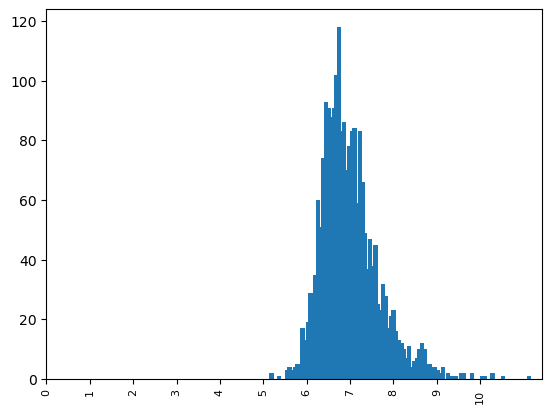

In [60]:


# prediction_l1 대한 히스토그램
plt.hist(prediction_l1, bins= 100, width = 0.1, align= 'left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation = 90 ,fontsize = 8)

# 평균, 중간값, 최빈값
print(prediction_l1.mean())
print(prediction_l1.median())
print(prediction_l1.mode())

# target 'rating'에 대한 히스토그램
plt.hist(data['rating'], bins= 100, width = 0.1, align= 'left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation = 90 ,fontsize = 8)

Text(0.5, 1.0, 'Histogram of ratings')

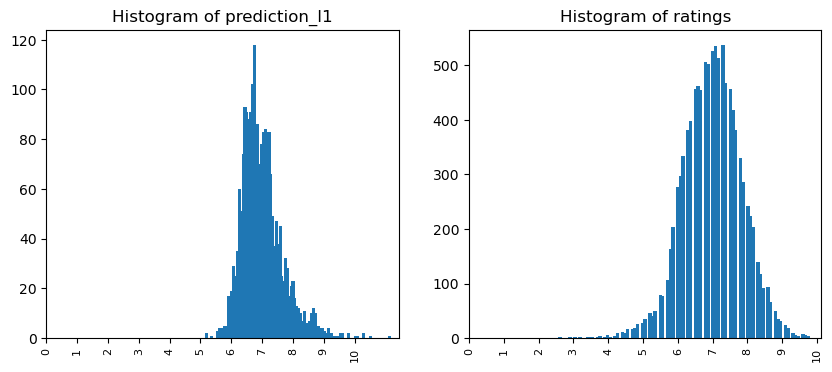

In [26]:
# prediction_l1에 대한 히스토그램
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(prediction_l1, bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of prediction_l1')


# target 'rating'에 대한 히스토그램
plt.subplot(1, 2, 2)
plt.hist(data['rating'], bins=100, width=0.1, align='left')
plt.xticks(np.arange(0, 11, 1))
plt.xticks(rotation=90, fontsize=8)
plt.title('Histogram of ratings')